In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [10]:
dir_list = {
    0: '../data/Trends Smart City/0EG/',
    1: '../data/Trends Smart City/1OG/',
    2: '../data/Trends Smart City/2OG/',
    3: '../data/Trends Smart City/3OG/'
}
file_list = {
    0: os.listdir(dir_list[0]),
    1: os.listdir(dir_list[1]),
    2: os.listdir(dir_list[2]),
    3: os.listdir(dir_list[3])
}

{0: '../data/Trends Smart City/0EG/',
 1: '../data/Trends Smart City/1OG/',
 2: '../data/Trends Smart City/2OG/',
 3: '../data/Trends Smart City/3OG/'}

In [99]:
rooms_temp = []
names_temp = []
rooms_qual = []
names_qual = []

for floor in dir_list.keys():
    for file in file_list[floor]:
        room_df = pd.read_csv(
            dir_list[floor] + file,
            sep=';',
            parse_dates=True,
            header=0,
            index_col=0,
            names=[file.split()[0], '_1', '_2', '_3'],
            )
        room_df.index.name = 'Time'
        if file.split()[1][:-4] == 'Lufttemp':
            names_temp.append(file.split()[0])
            rooms_temp.append(room_df.iloc[:,0].dropna().tolist())
        else:
            names_qual.append(file.split()[0])
            rooms_qual.append(room_df.iloc[:,0].dropna().tolist())

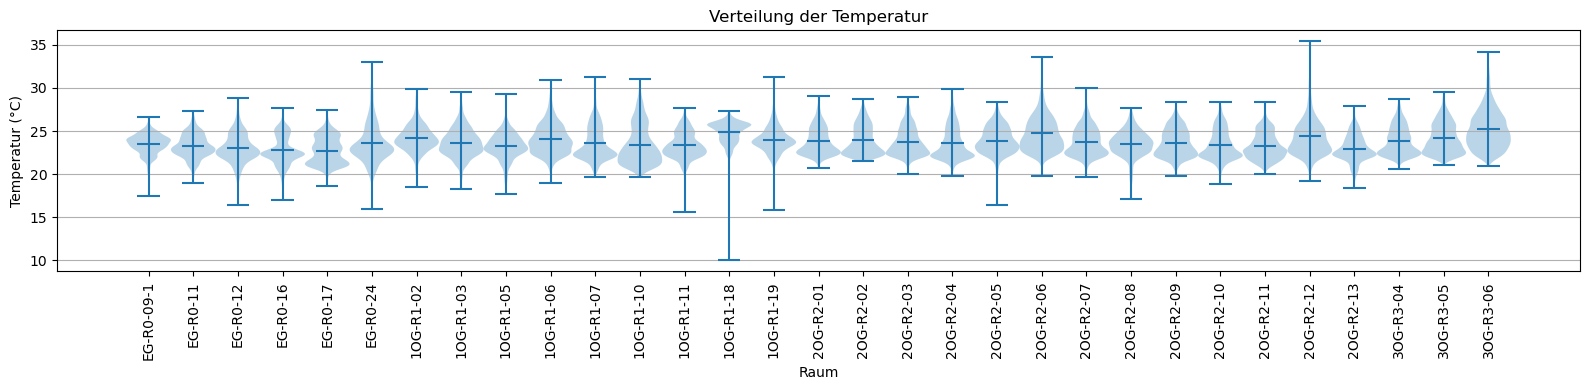

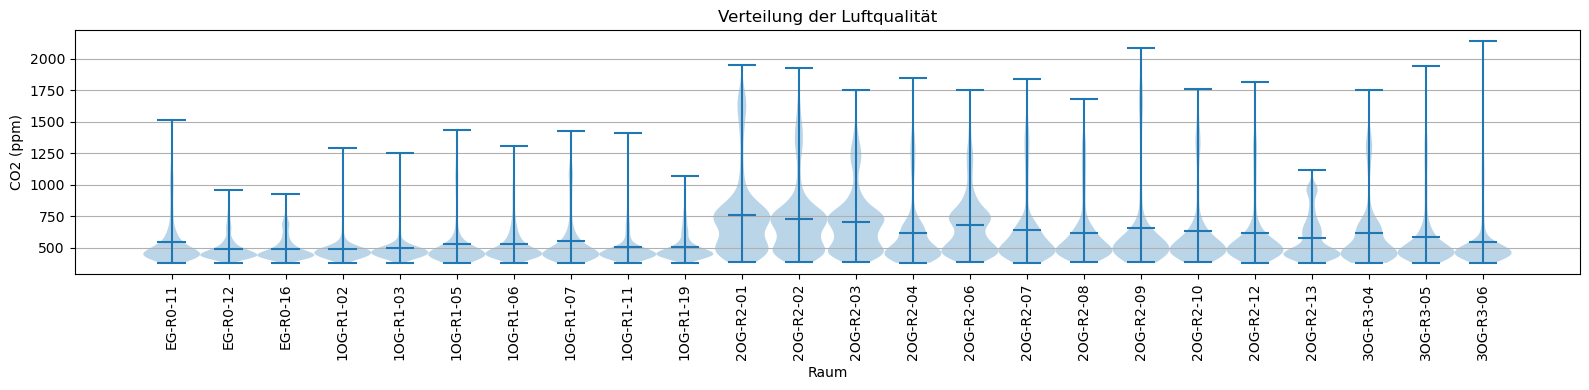

In [106]:
for rooms, names, title, yaxis in zip(
    [rooms_temp, rooms_qual],
    [names_temp, names_qual],
    ["Temperatur", "Luftqualität"],
    ['Temperatur (°C)', 'CO2 (ppm)']
    ):
    fig, ax = plt.subplots(figsize=(16, 4))

    ax.violinplot(rooms, widths=1, showmeans=True, showextrema=True)
    ax.set_title('Verteilung der ' + title)
    ax.set_xlabel('Raum')
    ax.set_ylabel(yaxis)
    ax.set_xticks(ticks=np.arange(1, len(rooms)+1), labels=names, rotation='vertical')
    plt.grid(axis='y')
    plt.tight_layout()

    plt.savefig("../plots/distribution_plots/Distribution " + title + ".png")
    plt.show()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

array([[3.85478726, 4.29819473, 4.02225051],
       [2.3486438 , 4.66214816, 4.24879781],
       [3.4177292 , 4.73735358, 3.17410604],
       [2.21016479, 5.18771732, 3.50857041],
       [2.8211053 , 5.06543668, 4.12354268],
       [2.76301736, 5.214805  , 3.62931532],
       [5.19481147, 3.62328627, 4.87036695],
       [2.45129925, 4.2241293 , 2.37337427],
       [2.91777791, 4.53092004, 3.1527415 ],
       [3.35802889, 5.59000363, 4.2833225 ],
       [3.44626898, 6.14332293, 4.05273911],
       [2.23279736, 4.98171906, 3.69662614],
       [2.87696435, 5.53508332, 4.60493847],
       [3.23504255, 4.41132958, 3.66460781],
       [3.15463228, 4.87995367, 3.62943171],
       [4.37026037, 5.77705647, 4.40062342],
       [3.2241124 , 5.88913069, 3.41921576],
       [3.42886865, 4.72651801, 4.21394876],
       [3.86664691, 5.17975799, 4.49974952],
       [2.78729307, 4.55219743, 3.73588523],
       [2.55219033, 3.78790457, 3.50077198],
       [1.95549183, 3.93199038, 5.61591326],
       [2.